In [88]:
import os
import pandas as pd

def aggregate_pred_dataframe(files):
    dfs = [pd.read_csv(f) for f in files]
    final_df = dfs[0].rename(columns={'pred': 'pred_0'})
    for i in range(1, len(dfs)):
        final_df[f'pred_{i}'] = dfs[i]['pred']
    return final_df.reset_index()

def get_preds_with_prefixes(prefixes, seed_start=0, seed_end=20):
    if prefixes is str:
        prefixes = [prefixes]
    csv_files = [file for file in os.listdir('preds') if file.endswith('.csv')]
    csv_files.sort()
    len(csv_files)
    preds = []
    for seed in range(seed_start, seed_end):
        for prefix in prefixes:
            filtered = [file for file in csv_files if file.startswith(f'{prefix}_{seed}')] # get all file with same seed
            if filtered:
                preds.append((filtered[-1], filtered[-2])) # get the one with highest mcc value (valid and test)
    return preds

def aggregate_preds(preds):
    df_valid = aggregate_pred_dataframe([f'preds/{i[0]}' for i in preds])
    df_test = aggregate_pred_dataframe([f'preds/{i[1]}' for i in preds])
    
    return df_valid, df_test

%matplotlib inline
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, matthews_corrcoef
import matplotlib.pyplot as plt
import numpy as np

def round_dict(d, n):
    return {k: round(v, n) if isinstance(v, float) else v
                for k, v in d.items()}

def generate_mean_ensemble_metrics(df, threshold=0):
    sum_preds = df[list(filter(lambda a: a.startswith('pred_'), df.columns.tolist()))].mean(axis=1)
    final_prediction = (sum_preds > threshold).astype(int)

    # Sensitivity (Recall)
    sensitivity = recall_score(df['target'], final_prediction)

    # Specificity
    tn, fp, fn, tp = confusion_matrix(df['target'], final_prediction).ravel()
    specificity = tn / (tn + fp)

    # Accuracy
    accuracy = accuracy_score(df['target'], final_prediction)

    # Precision
    precision = precision_score(df['target'], final_prediction)
    mcc = matthews_corrcoef(df['target'], final_prediction)
    return {
        "sensitivity": sensitivity,
        "specificity": specificity,
        "accuracy": accuracy,
        "precision": precision,
        "mcc": mcc,
    }
    
def draw_mean_ensemble_thrshold_chart(df_valid, df_test, start=-3, end=1, step=0.1,
                                      plot=True):
    # Create a list of thresholds to test
    thresholds = np.arange(start, end, step)  # Adjust the step size as necessary
    valid_mccs = []
    test_metrics = []

    # Loop through thresholds and compute MCC
    for threshold in thresholds:
        metrics = generate_mean_ensemble_metrics(df_valid, threshold)
        valid_mccs.append(metrics['mcc'])
        
        metrics_test = generate_mean_ensemble_metrics(df_test, threshold)
        test_metrics.append(metrics_test)

    # Identify threshold with the best MCC
    best_threshold_arg = np.argmax(valid_mccs)
    best_threshold = thresholds[best_threshold_arg]

    label = f'Best Threshold: {best_threshold:.1f}, Valid MCC: {valid_mccs[best_threshold_arg]:.3f}, Test MCC: {test_metrics[best_threshold_arg]["mcc"]:.3f}'
    # Plot
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(thresholds, valid_mccs, label='Valid MCC', color='blue')
        plt.plot(thresholds, [i['mcc'] for i in test_metrics], label='Test MCC', color='green')
        plt.axvline(x=best_threshold, color='red', linestyle='--', label=label)
        plt.xlabel('Threshold')
        plt.ylabel('MCC Value')
        plt.title('MCC vs. Threshold')
        plt.legend()
        plt.grid(True)
        plt.show()
    return {
        'best_threshold': best_threshold, 
        'valid_mcc': valid_mccs[best_threshold_arg],
        **test_metrics[best_threshold_arg]
    }


def random_small_ensembles(preds, n, trial, start=-3, end=1, step=0.1):
    from random import sample
    df = pd.DataFrame()
    for i in range(trial):
        sample_preds = sample(preds, n)
        df_valid = aggregate_pred_dataframe([f'preds/{i[0]}' for i in sample_preds])
        df_test = aggregate_pred_dataframe([f'preds/{i[1]}' for i in sample_preds])
        new_row = [draw_mean_ensemble_thrshold_chart(df_valid, df_test, start=start, end=end, step=step, plot=False)]
        new_df = pd.DataFrame(new_row)
        df = pd.concat([df, new_df], ignore_index=True)

    return df


def summarize_prefix(prefixes, n, plot=False, start=-3, end=1, step=0.1, apply_sig=False, seed_start=0, seed_end=20):
    preds = get_preds_with_prefixes(prefixes, seed_start=seed_start, seed_end=seed_end)
    df_valid, df_test = aggregate_preds(preds)
    print(f'Ensemble of all {len(preds)} models:')
    
    if apply_sig:
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))
        # Apply the sigmoid function to all pred columns
        pred_columns = df_valid.filter(like='pred_').columns
        df_valid[pred_columns] = df_valid[pred_columns].apply(sigmoid)
        df_test[pred_columns] = df_test[pred_columns].apply(sigmoid)
    print(round_dict(draw_mean_ensemble_thrshold_chart(df_valid, df_test, start=start, end=end, step=step, plot=plot), 4))

    print(f'Ensemble of {n} random models:')
    df = random_small_ensembles(preds, n, 10, start=start, end=end, step=step)
    return df.aggregate(['mean', 'std', 'max']).T.round(3)


In [3]:
summarize_prefix('v001', n=10)

Ensemble of all 20 models:


KeyboardInterrupt: 

Ensemble of all 20 models:


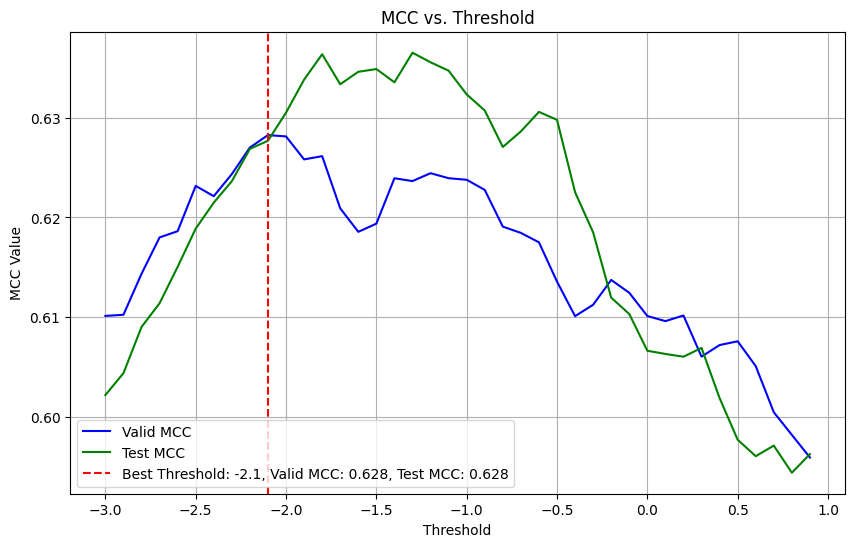

{'best_threshold': -2.1, 'valid_mcc': 0.6283, 'sensitivity': 0.5933, 'specificity': 0.9862, 'accuracy': 0.9659, 'precision': 0.7019, 'mcc': 0.6277}
Ensemble of 10 random models:


,mean,std,max
best_threshold,-1.750,0.521,-0.800
valid_mcc,0.626,0.002,0.630
sensitivity,0.576,0.021,0.606
specificity,0.987,0.002,0.991
accuracy,0.966,0.001,0.967
precision,0.717,0.024,0.764
mcc,0.625,0.005,0.633


In [7]:
summarize_prefix(['v006'], n=10, plot=True)

Ensemble of all 40 models:


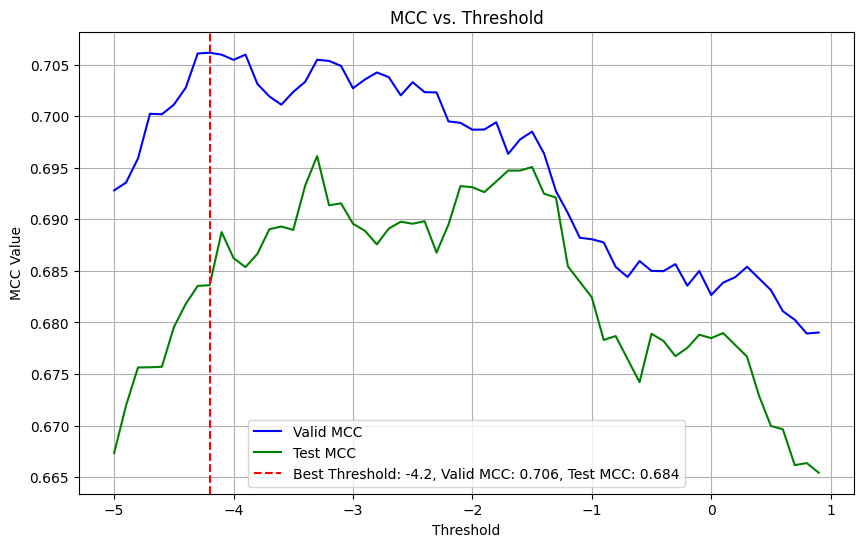

{'best_threshold': -4.2, 'valid_mcc': 0.7061, 'sensitivity': 0.7225, 'specificity': 0.9814, 'accuracy': 0.9679, 'precision': 0.6792, 'mcc': 0.6836}
Ensemble of 10 random models:


,mean,std,max
best_threshold,-3.110,0.682,-1.900
valid_mcc,0.704,0.004,0.711
sensitivity,0.688,0.021,0.715
specificity,0.985,0.002,0.988
accuracy,0.970,0.001,0.972
precision,0.716,0.027,0.755
mcc,0.686,0.005,0.694


In [91]:
summarize_prefix(['v014'], n=10, plot=True, start=-5, end=1, seed_start=0, seed_end=40)

Ensemble of all 40 models:


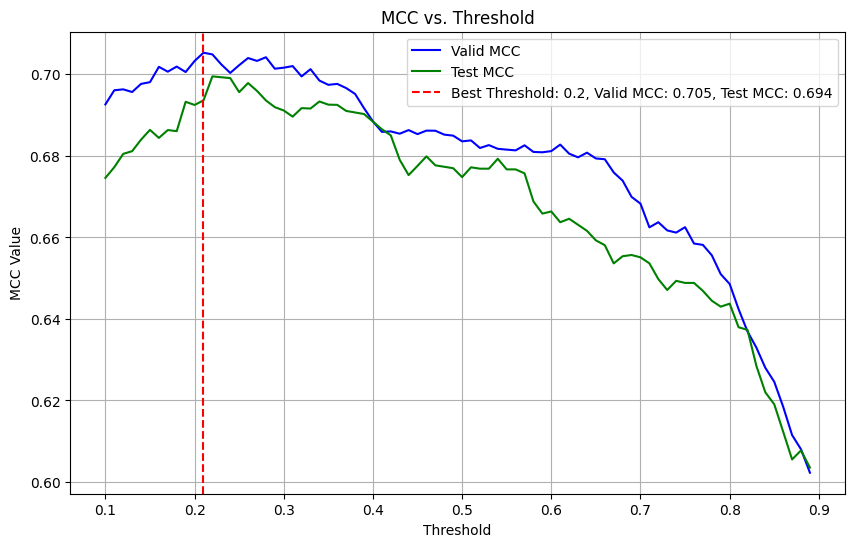

{'best_threshold': 0.21, 'valid_mcc': 0.7053, 'sensitivity': 0.7002, 'specificity': 0.985, 'accuracy': 0.9703, 'precision': 0.7185, 'mcc': 0.6936}
Ensemble of 10 random models:


,mean,std,max
best_threshold,0.205,0.154,0.590
valid_mcc,0.685,0.004,0.690
sensitivity,0.584,0.008,0.600
specificity,0.992,0.001,0.993
accuracy,0.971,0.000,0.972
precision,0.807,0.011,0.829
mcc,0.673,0.005,0.680


In [90]:
summarize_prefix(['v014'], n=10, plot=True, start=0.1, end=0.9, step=0.01, seed_start=0, seed_end=40, apply_sig=True)

In [14]:
preds = get_preds_with_prefixes(['v014'], seed_start=0, seed_end=40)
for n in range(1, 21):
    df = random_small_ensembles(preds, n, 10, start=-3, end=1)
    print(n, df.aggregate(['mean', 'std', 'max'])['mcc']['mean'])

1 0.6635811308863901
2 0.671973364047464
3 0.6770576334220839
4 0.6818196631616241
5 0.6821136712771967
6 0.6859563637921429
7 0.6904539273514726
8 0.6899295849080517
9 0.6896266650850954
10 0.6893191359075741
11 0.6916099256369422
12 0.6899069706153202
13 0.6907449400289546
14 0.6904275824327606
15 0.6914737439784175
16 0.6907220329421518
17 0.6915656336584514
18 0.6924790186540168
19 0.6919204127514338
20 0.6938883844092064


Ensemble of all 14 models:


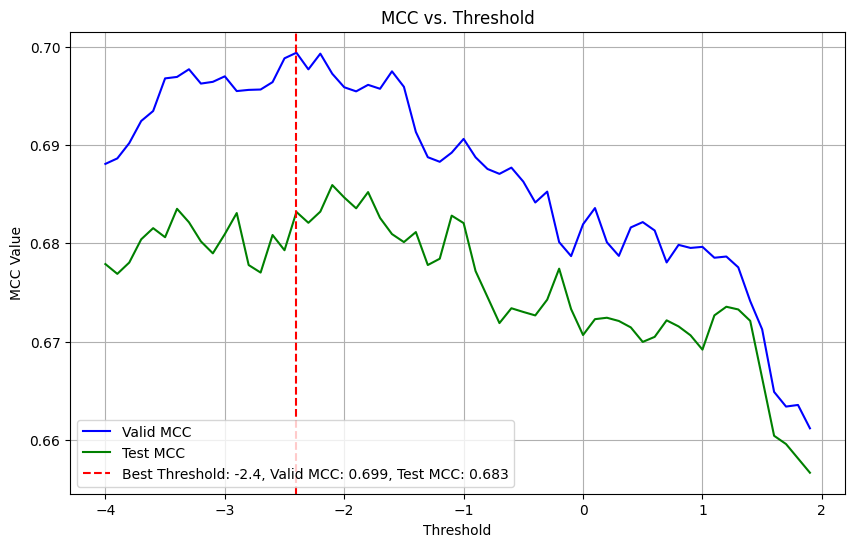

{'best_threshold': -2.4, 'valid_mcc': 0.6994, 'sensitivity': 0.6699, 'specificity': 0.9864, 'accuracy': 0.97, 'precision': 0.7292, 'mcc': 0.6832}
Ensemble of 10 random models:


,mean,std,max
best_threshold,-2.560,0.414,-2.000
valid_mcc,0.701,0.002,0.704
sensitivity,0.672,0.014,0.694
specificity,0.986,0.001,0.988
accuracy,0.970,0.001,0.971
precision,0.724,0.017,0.753
mcc,0.682,0.004,0.687


In [11]:
summarize_prefix(['v021'], n=10, plot=True, start=-4, end=2, seed_start=0, seed_end=40)

Ensemble of all 8 models:


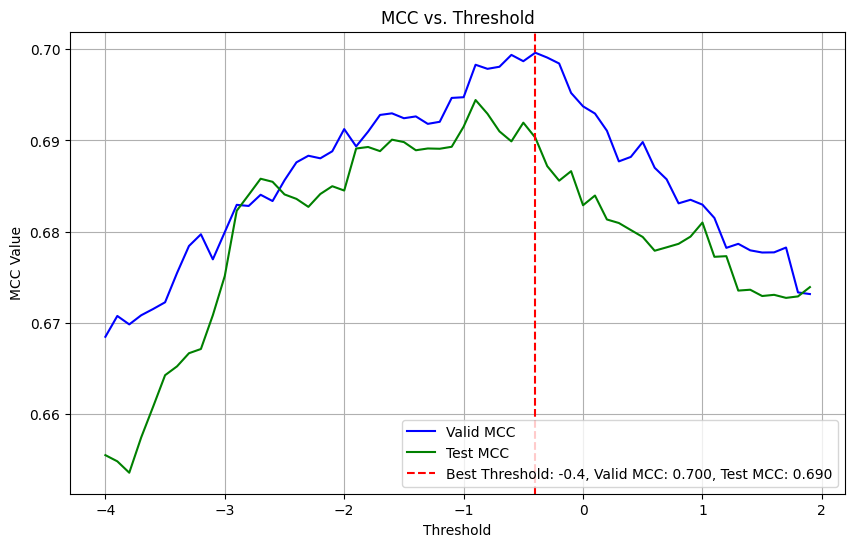

{'best_threshold': -0.4, 'valid_mcc': 0.6996, 'sensitivity': 0.6587, 'specificity': 0.9883, 'accuracy': 0.9713, 'precision': 0.755, 'mcc': 0.6903}
Ensemble of 5 random models:


,mean,std,max
best_threshold,-0.760,0.369,-0.200
valid_mcc,0.695,0.004,0.701
sensitivity,0.665,0.017,0.679
specificity,0.987,0.001,0.989
accuracy,0.970,0.001,0.971
precision,0.739,0.015,0.761
mcc,0.685,0.006,0.694


In [38]:
summarize_prefix(['v022'], n=5, plot=True, start=-4, end=2, seed_start=0, seed_end=40)

In [16]:
preds = get_preds_with_prefixes(['v014'], seed_start=0, seed_end=20)
df_valid, df_test = aggregate_preds(preds)

In [19]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Apply the sigmoid function to all pred columns
pred_columns = df_valid.filter(like='pred_').columns
df_valid[pred_columns] = df_valid[pred_columns].apply(sigmoid)
df_test[pred_columns] = df_test[pred_columns].apply(sigmoid)

Ensemble of all 20 models:


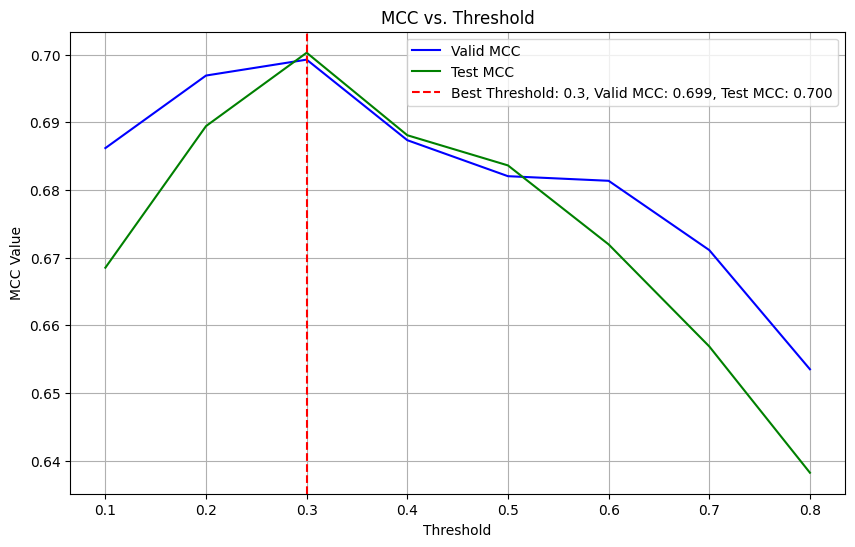

{'best_threshold': 0.3, 'valid_mcc': 0.6993, 'sensitivity': 0.6762, 'specificity': 0.9881, 'accuracy': 0.9719, 'precision': 0.7558, 'mcc': 0.7003}


In [35]:
print(f'Ensemble of all {len(preds)} models:')
print(round_dict(draw_mean_ensemble_thrshold_chart(df_valid, df_test, start=0.1, end=0.9, step=0.1, plot=True), 4))

summarize_prefix(['v014'], n=10, plot=True, start=0.1, end=0.9, step=0.01, seed_start=0, seed_end=20, use_sig=True)

In [1]:
summarize_prefix(['v014'], n=10, plot=True, start=-3, end=1, step=0.2, seed_start=0, seed_end=20, apply_sig=False)

NameError: name 'summarize_prefix' is not defined

Ensemble of all 26 models:


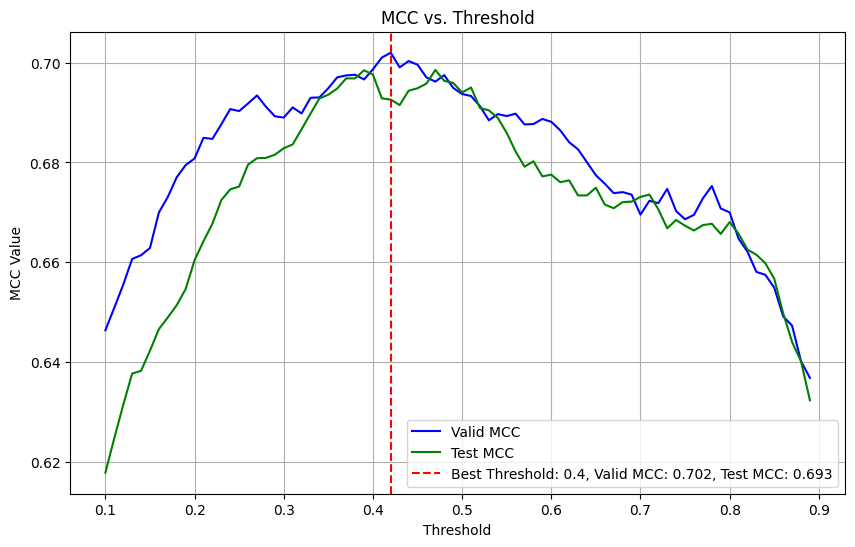

{'best_threshold': 0.42, 'valid_mcc': 0.702, 'sensitivity': 0.6874, 'specificity': 0.9861, 'accuracy': 0.9706, 'precision': 0.7293, 'mcc': 0.6926}
Ensemble of 10 random models:


,mean,std,max
best_threshold,0.217,0.165,0.660
valid_mcc,0.694,0.003,0.697
sensitivity,0.641,0.010,0.662
specificity,0.989,0.001,0.990
accuracy,0.971,0.000,0.972
precision,0.762,0.010,0.776
mcc,0.684,0.004,0.692


In [45]:
summarize_prefix(['v022'], n=10, plot=True, start=0.1, end=0.9, step=0.01, seed_start=0, seed_end=40, apply_sig=True)

Ensemble of all 26 models:


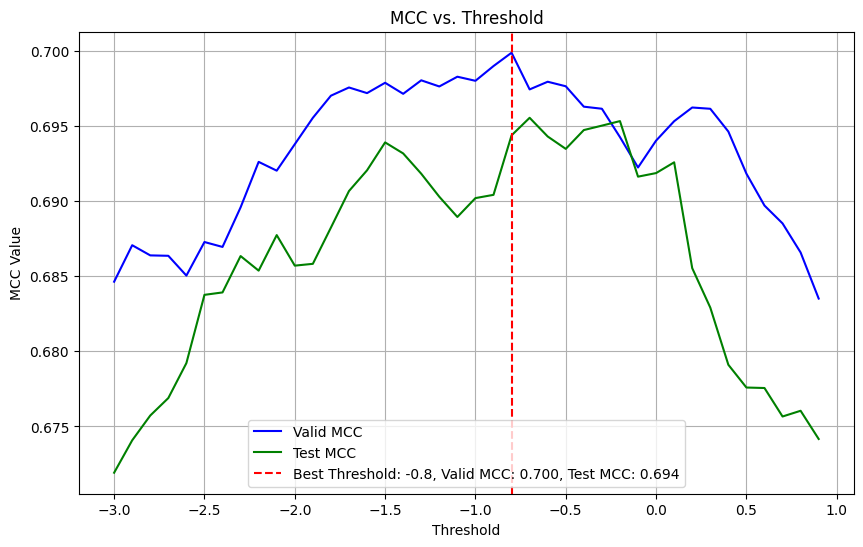

{'best_threshold': -0.8, 'valid_mcc': 0.6999, 'sensitivity': 0.6794, 'specificity': 0.987, 'accuracy': 0.9711, 'precision': 0.7409, 'mcc': 0.6944}
Ensemble of 10 random models:


,mean,std,max
best_threshold,-1.040,0.833,0.100
valid_mcc,0.696,0.003,0.700
sensitivity,0.673,0.021,0.702
specificity,0.986,0.002,0.990
accuracy,0.970,0.001,0.971
precision,0.728,0.022,0.770
mcc,0.684,0.004,0.690


In [46]:
summarize_prefix(['v022'], n=10, plot=True, start=-3, end=1, step=0.1, seed_start=0, seed_end=40, apply_sig=False)